

## Convolutional Neural Networks

---

In this notebook, we train a CNN to classify images from the CIFAR-10 database.

The training is performed on an AWS GPU instance

### 1. Load CIFAR-10 Database

In [1]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


Untaring file...


### 2. Visualize 24 random Training Images

Training/Testing sets contain 50000/10000 images of shape (32, 32, 3)
There are 10 unique target classes


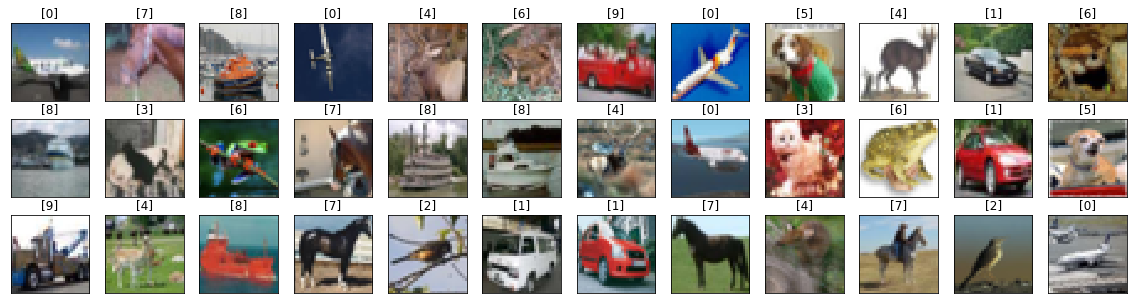

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample

print("Training/Testing sets contain {}/{} images of shape {}".format(
    x_train.shape[0], x_test.shape[0], x_train.shape[1:]))
print("There are {} unique target classes".format(np.unique(y_train).size))

# pick 36 random pictures from the training dataset
imgIdx = sample(range(1, len(x_train)), 36)

fig = plt.figure(figsize=(20,5))
for i, n in enumerate(imgIdx):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[n]))
    ax.set_title(str(y_train[n]))

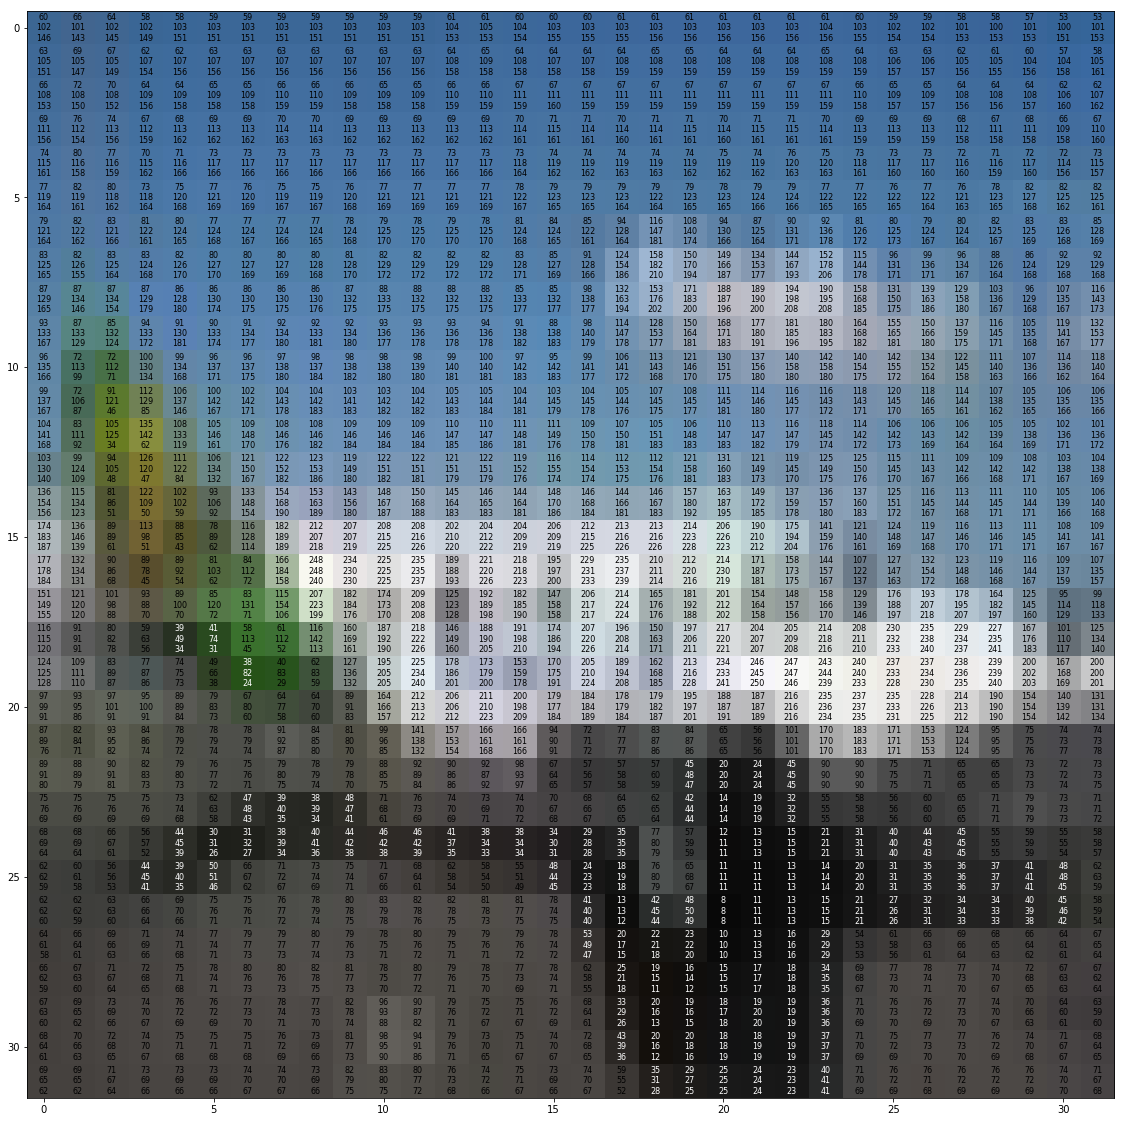

In [3]:
# view in more details

def visualize_input(img, ax):
    ax.imshow(img)
    width, height, color = img.shape
    for x in range(width):
        for y in range(height):
            ax.annotate("\n".join([str(x) for x in img[x,y,:]]), 
                        xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x,y,:].mean()<50 else 'black',
                        size=8
                        )


fig = plt.figure(figsize = (20,20)) 
ax = fig.add_subplot(111)
visualize_input(x_train[imgIdx[0]], ax)

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [4]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [5]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Define the Model Architecture 

In [52]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import rmsprop 

'''
# initial CNN
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()
'''

#CNN from keras-team
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 15, 15, 64)        18496     
__________

### 6. Compile the Model 

In [53]:
# initiate RMSprop optimizer
opt = rmsprop(lr=0.0001, decay=1e-6)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])

### 7. Train the Model 

In [54]:
from keras.callbacks import ModelCheckpoint   
from time import time
# train the model
# on CPU: about 40s per epoch, acc = 66% after with 10 epochs
checkpointer = ModelCheckpoint(filepath='model_gpu.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

start = time()

hist = model.fit(x_train, y_train, batch_size=32, epochs=50, #100 in original setting
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

print("Training done, total elapsed time = {:.2f}".format(time()-start))

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 1.59077, saving model to model.weights.best.hdf5
19s - loss: 1.8600 - acc: 0.3159 - val_loss: 1.5908 - val_acc: 0.4302
Epoch 2/50
Epoch 00001: val_loss did not improve
18s - loss: 1.5427 - acc: 0.4362 - val_loss: 1.8925 - val_acc: 0.3694
Epoch 3/50
Epoch 00002: val_loss improved from 1.59077 to 1.54769, saving model to model.weights.best.hdf5
18s - loss: 1.4043 - acc: 0.4947 - val_loss: 1.5477 - val_acc: 0.4744
Epoch 4/50
Epoch 00003: val_loss improved from 1.54769 to 1.21677, saving model to model.weights.best.hdf5
18s - loss: 1.2988 - acc: 0.5380 - val_loss: 1.2168 - val_acc: 0.5772
Epoch 5/50
Epoch 00004: val_loss improved from 1.21677 to 1.11171, saving model to model.weights.best.hdf5
18s - loss: 1.2221 - acc: 0.5687 - val_loss: 1.1117 - val_acc: 0.6056
Epoch 6/50
Epoch 00005: val_loss did not improve
18s - loss: 1.1527 - acc: 0.5955 - val_loss: 1.1366 - val_acc: 0.6012
Epoch 7/5

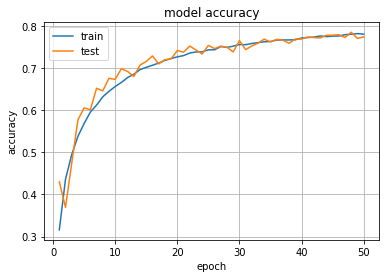

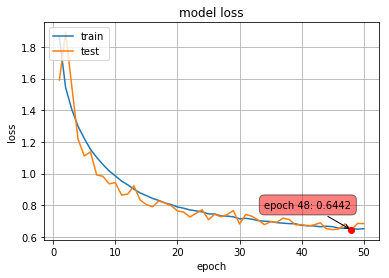

In [55]:
def plotHistory(hist):
    e = [x+1 for x in hist.epoch]
    
    val_loss_history = hist.history['val_loss']
    minValLossVal = min(val_loss_history)
    minValLossIdx = val_loss_history.index(minValLossVal)+1   
    
    # summarize history for accuracy
    plt.plot(e, hist.history['acc'])
    plt.plot(e, hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(e, hist.history['loss'])
    plt.plot(e, hist.history['val_loss'])
    plt.plot(minValLossIdx, minValLossVal, 'or')
    plt.annotate(
        "epoch {}: {:.4f}".format(minValLossIdx, minValLossVal),
        xy=(minValLossIdx, minValLossVal), xytext=(0, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()
    
plotHistory(hist)

### 8. Load the Model with the Best Validation Accuracy

In [56]:
# load the weights that yielded the best validation accuracy
model.load_weights('model_gpu.weights.best.hdf5')

### 9. Calculate Classification Accuracy on Test Set

In [57]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7799


### 10. Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

In [58]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

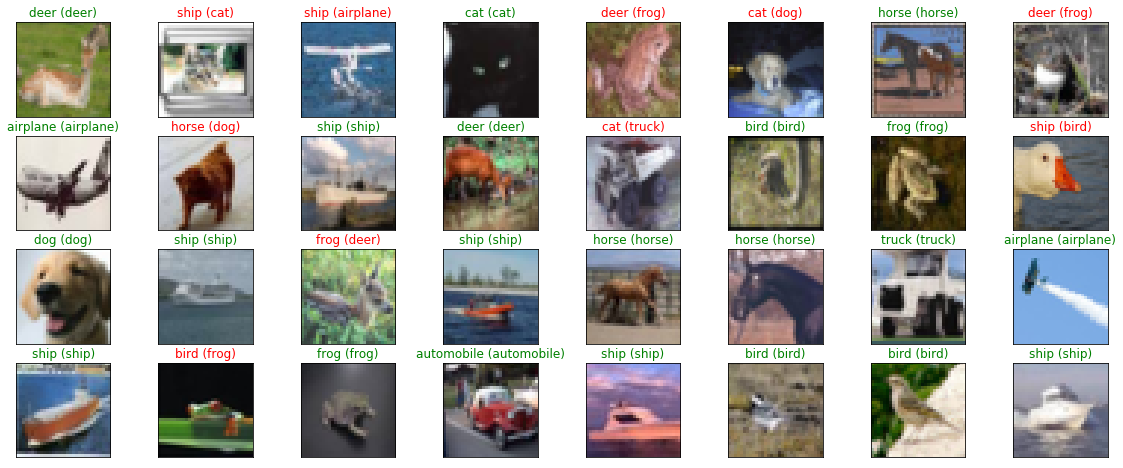

In [59]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))